# Metrics of classification probabilities

TODO: change double float probs to integers, for less space/volume of data, could precompute from binned probabilities, check that it can be done in sql

also check the probabilities sum to 1 at some point
and allow submissions for negative of class
and flags for did not classify and reasons

In [1]:
%matplotlib inline
import sys
import os
import requests
import datetime
import dateutil.parser
import json
import numpy
import pandas
import matplotlib.pyplot as plt
import sklearn
import sklearn.metrics

In [2]:
 os.getenv("HOME")

'/home/aimalz'

In [3]:
url = "https://desc-tom.lbl.gov"
# url = "https://desc-tom-rknop-dev.lbl.gov"

# Somehow you need to set the "username" and "password" variables.
# Do NOT hardcode the password into any code that will be world
# readable.  You can use the python input statement, or, as I do
# here, read the password from a file that is only readable by
# you.  (This isn't perfect, but it's better than having the
# password sit around in a world readable file.)
username = "aimalz"#"rknop"
with open( os.path.join( os.getenv("HOME"), "secrets", "tom_"+username+"_passwd" ) ) as ifp:
    password = ifp.readline().strip()

In [4]:
rqs = requests.session()
rqs.get( f'{url}/accounts/login/' )
res = rqs.post( f'{url}/accounts/login/',
                data={ "username": username,
                       "password": password,
                       "csrfmiddlewaretoken": rqs.cookies['csrftoken'] } )
if res.status_code != 200:
    raise RuntimeError( f"Failed to log in; http status: {res.status_code}" )
if 'Please enter a correct' in res.text:
    raise RuntimeError( "Failed to log in.  I think.  Put in a debug break and look at res.text" )
rqs.headers.update( { 'X-CSRFToken': rqs.cookies['csrftoken'] } )

In [5]:
def run_query(query, subdict=None):
    if subdict == None:
        subdict = {}
    result = rqs.post( f'{url}/db/runsqlquery/',
        json={ 'query': query, 'subdict': subdict } )
    if result.status_code != 200:
        sys.stderr.write( f"ERROR: got status code {result.status_code} ({result.reason})\n" )
    else:
        data = json.loads( result.text )
        if ( 'status' not in data ) or ( data['status'] != 'ok' ):
            sys.stderr.write( "Got unexpected response\n" )
            print(data['error'])
        else:
            return data['rows']

In [6]:
rows = run_query( 'SELECT "classifierId","brokerName","brokerVersion",'
                  '"classifierName","classifierParams" '
                  'FROM elasticc_brokerclassifier' )
classifier_info = {}
for row in rows:
    classifier_info[row["classifierId"]] = row             
classifier_info

{36: {'classifierId': 36,
  'brokerName': 'AMPEL',
  'brokerVersion': 'v0.2',
  'classifierName': 'ElasticcLiveSNGuess',
  'classifierParams': 'XGBUnified+Parsnip04'},
 37: {'classifierId': 37,
  'brokerName': 'AMPEL',
  'brokerVersion': 'v0.2',
  'classifierName': 'ElasticcLive',
  'classifierParams': 'XGBUnified+Parsnip04'},
 38: {'classifierId': 38,
  'brokerName': 'AMPEL',
  'brokerVersion': 'v0.2',
  'classifierName': 'ElasticcLiveSNGuessParsnip',
  'classifierParams': 'XGBUnified+Parsnip04'},
 39: {'classifierId': 39,
  'brokerName': 'AMPEL',
  'brokerVersion': 'v0.2',
  'classifierName': 'ElasticcLiveSNGuessParsnipPrior',
  'classifierParams': 'XGBUnified+Parsnip04'},
 40: {'classifierId': 40,
  'brokerName': 'ALeRCE',
  'brokerVersion': '3.1.0',
  'classifierName': 'balto',
  'classifierParams': '3.1.0'},
 41: {'classifierId': 41,
  'brokerName': 'ALeRCE',
  'brokerVersion': '1.0.0',
  'classifierName': 'messi',
  'classifierParams': '1.0.0'},
 42: {'classifierId': 42,
  'broke

TODO: select just a couple classifiers/brokers

In [7]:
use_cfers = {i: classifier_info[i] for i in [40,44]}
use_cfers

{40: {'classifierId': 40,
  'brokerName': 'ALeRCE',
  'brokerVersion': '3.1.0',
  'classifierName': 'balto',
  'classifierParams': '3.1.0'},
 44: {'classifierId': 44,
  'brokerName': 'ANTARES',
  'brokerVersion': '2.0.0',
  'classifierName': 'LiCuParsnip_filter',
  'classifierParams': 'v2'}}

In [8]:
rows = run_query( 'SELECT DISTINCT ON ("classId") "classId",description '
                  'FROM elasticc_gentypeofclassid '
                  'ORDER BY "classId"' )
classname = {}
for row in rows:
    classname[row["classId"]] = row["description"]

In [9]:
classname

{0: 'Static/Other',
 1: 'Non-Recurring',
 2: 'Recurring',
 10: 'Non-Recurring/Other',
 11: 'SN-like',
 12: 'Fast',
 13: 'Long',
 20: 'Recurring/Other',
 21: 'Periodic',
 22: 'Non-Periodic',
 110: 'SN-like/Other',
 111: 'Ia',
 112: 'Ib/c',
 113: 'II',
 114: 'Iax',
 115: '91bg',
 120: 'Fast/Other',
 121: 'KN',
 122: 'M-dwarf Flare',
 123: 'Dwarf Nova',
 124: 'uLens',
 130: 'Long/Other',
 131: 'SLSN',
 132: 'TDE',
 133: 'ILOT',
 134: 'CART',
 135: 'PISN',
 210: 'Periodic/Other',
 211: 'Cepheid',
 212: 'RR Lyrae',
 213: 'Delta Scuti',
 214: 'EB',
 215: 'LPV/Mira',
 220: 'Non-Periodic/Other',
 221: 'AGN'}

## Everything above here is setup.  Run all that.  Then pick and choose below.

In [10]:
# consider descIngestTimestamp, alertSentTimestamp
#
# alertSentTimestamp -- this gets updated in the database when the original
#    alert is sent out.  It's NOT present in the dev database, but should
#    be in the real one
# descIngestTimestamp -- just when we happend to suck in the broker message
#
# alertId -- opaque fingerprint, don't sort on it, but it does correspond to
#   the original alert.  Different alertId = different source, i.e.
#   measurement of the transient.

sys.stderr.write( f"Query start at {datetime.datetime.now().isoformat()}...\n" )
query = ( 'SELECT '
          '  "classifierId","diaObjectId","classId","alertId","trueClassId","probability","descIngestTimestamp" '
          'FROM elasticc_view_sourceclassifications '
          'ORDER BY "diaObjectId","descIngestTimestamp","classifierId" '
          'OFFSET 100 LIMIT 100' )
rows = run_query( query )
sys.stderr.write( f"Query done at {datetime.datetime.now().isoformat()}\n" )
data = pandas.DataFrame( rows )
data
# classifiers = data.classifierId.unique()

Query start at 2022-12-15T14:57:33.240721...
Query done at 2022-12-15T14:57:35.721631


,classifierId,diaObjectId,classId,alertId,trueClassId,probability,descIngestTimestamp
0,80,1000038,215,2000076121,113,0.000000e+00,2022-12-10T20:41:26.727Z
1,80,1000038,220,2000076121,113,0.000000e+00,2022-12-10T20:41:26.727Z
2,80,1000038,120,2000076121,113,0.000000e+00,2022-12-10T20:41:26.727Z
3,80,1000038,130,2000076121,113,0.000000e+00,2022-12-10T20:41:26.727Z
4,42,1000038,221,2000076121,113,5.594780e-02,2022-12-10T20:41:26.728Z
...,...,...,...,...,...,...,...
95,41,1000174,122,2000348000,113,6.963106e-27,2022-12-07T02:06:40.821Z
96,41,1000174,135,2000348000,113,3.072997e-16,2022-12-07T02:06:40.821Z
97,41,1000174,212,2000348000,113,1.763961e-16,2022-12-07T02:06:40.821Z
98,41,1000174,131,2000348000,113,8.077484e-12,2022-12-07T02:06:40.821Z


TODO: change double float probs to integers, for less space/volume of data
also check the probabilities sum to 1 at some point
and allow submissions for negative of class
and flags for did not classify and reasons

In [11]:
sys.stderr.write( f"Query start at {datetime.datetime.now().isoformat()}...\n" )
query = ( 'SELECT '
          '  "classifierId","diaObjectId","classId","alertId","trueClassId","probability","descIngestTimestamp","alertSentTimestamp" '
          'FROM elasticc_view_sourceclassifications '
          'WHERE "classifierId"=41 AND "classId"=111 AND "trueClassId"=111 '
          'ORDER BY "diaObjectId","descIngestTimestamp" '
          'OFFSET 100 LIMIT 100' )
rows = run_query( query )
sys.stderr.write( f"Query done at {datetime.datetime.now().isoformat()}\n" )
data = pandas.DataFrame( rows )
data

Query start at 2022-12-15T14:57:35.776863...
Query done at 2022-12-15T14:57:58.752984


,classifierId,diaObjectId,classId,alertId,trueClassId,probability,descIngestTimestamp,alertSentTimestamp
0,41,1003330,111,2006660055,111,2.405586e-01,2022-11-27T21:28:43.173Z,2022-11-27T20:52:51.483Z
1,41,1003330,111,2006660057,111,7.859872e-02,2022-11-28T20:49:37.834Z,2022-11-28T20:15:28.501Z
2,41,1003330,111,2006660058,111,5.613366e-02,2022-11-28T20:54:12.790Z,2022-11-28T20:16:30.063Z
3,41,1003330,111,2006660063,111,2.854418e-02,2022-11-29T20:32:59.080Z,2022-11-29T20:29:33.532Z
4,41,1003330,111,2006660066,111,3.136482e-01,2022-11-30T02:40:35.129Z,2022-11-30T01:52:34.897Z
...,...,...,...,...,...,...,...,...
95,41,1006052,111,2012104015,111,5.731732e-07,2022-11-07T02:57:52.919Z,2022-11-06T21:59:53.852Z
96,41,1006052,111,2012104016,111,1.798039e-06,2022-11-07T03:34:34.063Z,2022-11-06T22:07:05.791Z
97,41,1006052,111,2012104017,111,1.654458e-03,2022-11-07T03:42:50.384Z,2022-11-06T22:07:59.839Z
98,41,1006052,111,2012104018,111,3.065239e-03,2022-11-07T22:52:54.928Z,2022-11-07T20:39:26.731Z


In [12]:
import numpy as np
np.unique(data['diaObjectId'], return_counts=True)

(array([1003330, 1003377, 1003402, 1003722, 1003806, 1003878, 1004142,
        1004205, 1004461, 1004475, 1004497, 1004610, 1004688, 1004893,
        1004913, 1004931, 1004978, 1005358, 1005627, 1005628, 1005646,
        1005738, 1005787, 1005839, 1005956, 1006052]),
 array([ 6, 10,  2, 11,  3,  1,  4,  3,  2,  2,  8,  1,  2,  4,  2,  1,  5,
         1,  1,  2,  5,  3,  2,  1,  8, 10]))

In [13]:
chosen = 1006052#1003722

In [14]:
data[ data['diaObjectId'] == chosen]#1025381 ]

,classifierId,diaObjectId,classId,alertId,trueClassId,probability,descIngestTimestamp,alertSentTimestamp
90,41,1006052,111,2012104008,111,6.936774e-10,2022-11-05T11:11:38.956Z,2022-11-04T22:42:36.608Z
91,41,1006052,111,2012104009,111,1.581636e-06,2022-11-06T00:16:16.213Z,2022-11-05T20:58:15.526Z
92,41,1006052,111,2012104011,111,2.350404e-02,2022-11-06T22:08:14.723Z,2022-11-06T20:48:17.581Z
93,41,1006052,111,2012104012,111,2.235560e-04,2022-11-06T22:10:11.653Z,2022-11-06T20:48:41.619Z
94,41,1006052,111,2012104013,111,1.695165e-08,2022-11-07T01:08:33.449Z,2022-11-06T21:36:26.610Z
95,41,1006052,111,2012104015,111,5.731732e-07,2022-11-07T02:57:52.919Z,2022-11-06T21:59:53.852Z
96,41,1006052,111,2012104016,111,1.798039e-06,2022-11-07T03:34:34.063Z,2022-11-06T22:07:05.791Z
97,41,1006052,111,2012104017,111,1.654458e-03,2022-11-07T03:42:50.384Z,2022-11-06T22:07:59.839Z
98,41,1006052,111,2012104018,111,3.065239e-03,2022-11-07T22:52:54.928Z,2022-11-07T20:39:26.731Z
99,41,1006052,111,2012104019,111,5.692855e-04,2022-11-07T22:58:29.966Z,2022-11-07T20:40:02.672Z


In [15]:
# All these joins suggest we need a new view.
sys.stderr.write( f"Query start at {datetime.datetime.now().isoformat()}...\n" )
query = ( 'SELECT '
          '  v."classifierId",v."diaObjectId",v."classId",v."alertId",v."trueClassId",v."probability",v."alertSentTimestamp", '
          '  s."midPointTai" '
          'FROM elasticc_view_sourceclassifications v '
          'INNER JOIN elasticc_diasource s ON v."diaSourceId"=s."diaSourceId" '
          'WHERE v."diaObjectId"='+str(chosen)+' AND "classId"=111 AND "trueClassId"=111 '
          'ORDER BY "classifierId","alertSentTimestamp" ' )
rows = run_query( query )
sys.stderr.write( f"Query done at {datetime.datetime.now().isoformat()}\n" )
data = pandas.DataFrame( rows )
data

Query start at 2022-12-15T14:57:58.985256...
Query done at 2022-12-15T14:57:59.501322


,classifierId,diaObjectId,classId,alertId,trueClassId,probability,alertSentTimestamp,midPointTai
0,40,1006052,111,2012104008,111,0.100034,2022-11-04T22:42:36.608Z,60611.3669
1,40,1006052,111,2012104009,111,0.046289,2022-11-05T20:58:15.526Z,60612.3552
2,40,1006052,111,2012104011,111,0.064897,2022-11-06T20:48:17.581Z,60626.3207
3,40,1006052,111,2012104012,111,0.115420,2022-11-06T20:48:41.619Z,60626.3326
4,40,1006052,111,2012104013,111,0.233964,2022-11-06T21:36:26.610Z,60632.3355
...,...,...,...,...,...,...,...,...
136,83,1006052,111,2012104025,111,0.038187,2022-11-07T23:01:45.661Z,60646.2967
137,83,1006052,111,2012104026,111,0.038102,2022-11-07T23:12:11.685Z,60647.3075
138,83,1006052,111,2012104027,111,0.029178,2022-11-07T23:12:33.636Z,60647.3187
139,83,1006052,111,2012104039,111,0.997230,2022-11-09T21:20:40.833Z,60667.2721


In [16]:
pandas.set_option('display.max_rows', 500)
data['t'] = data['alertSentTimestamp'].apply( lambda thing : dateutil.parser.isoparse( thing ) )
data.columns


Index(['classifierId', 'diaObjectId', 'classId', 'alertId', 'trueClassId',
       'probability', 'alertSentTimestamp', 'midPointTai', 't'],
      dtype='object')

In [17]:
classifier_info

{36: {'classifierId': 36,
  'brokerName': 'AMPEL',
  'brokerVersion': 'v0.2',
  'classifierName': 'ElasticcLiveSNGuess',
  'classifierParams': 'XGBUnified+Parsnip04'},
 37: {'classifierId': 37,
  'brokerName': 'AMPEL',
  'brokerVersion': 'v0.2',
  'classifierName': 'ElasticcLive',
  'classifierParams': 'XGBUnified+Parsnip04'},
 38: {'classifierId': 38,
  'brokerName': 'AMPEL',
  'brokerVersion': 'v0.2',
  'classifierName': 'ElasticcLiveSNGuessParsnip',
  'classifierParams': 'XGBUnified+Parsnip04'},
 39: {'classifierId': 39,
  'brokerName': 'AMPEL',
  'brokerVersion': 'v0.2',
  'classifierName': 'ElasticcLiveSNGuessParsnipPrior',
  'classifierParams': 'XGBUnified+Parsnip04'},
 40: {'classifierId': 40,
  'brokerName': 'ALeRCE',
  'brokerVersion': '3.1.0',
  'classifierName': 'balto',
  'classifierParams': '3.1.0'},
 41: {'classifierId': 41,
  'brokerName': 'ALeRCE',
  'brokerVersion': '1.0.0',
  'classifierName': 'messi',
  'classifierParams': '1.0.0'},
 42: {'classifierId': 42,
  'broke

In [18]:
# for i,cfer in enumerate(classifiers):
#     print(cfer,classifier_info[cfer]["brokerName"],classifier_info[cfer]["classifierName"],classifier_info[cfer]["brokerVersion"])

In [19]:
blind = False

/tmp/ipykernel_1195946/328870598.py:16: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


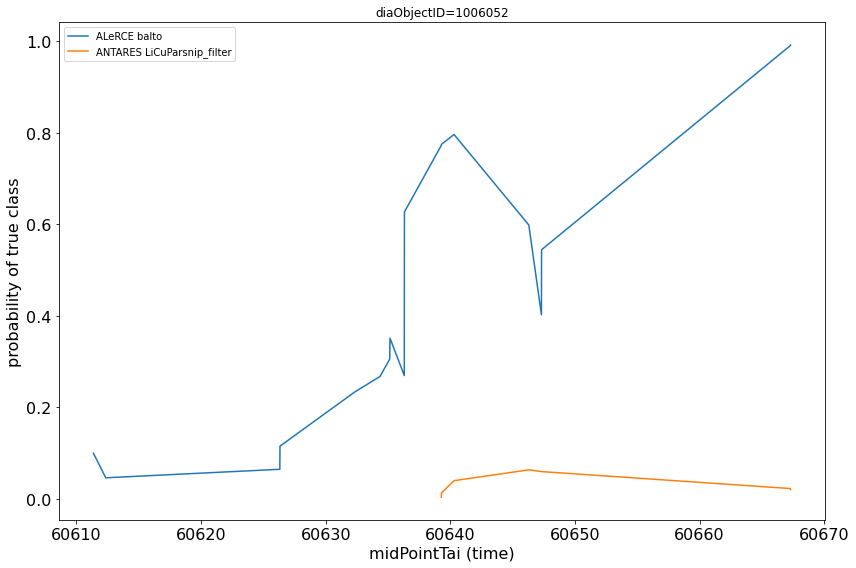

In [20]:
    
# TODO: color for broker, linestyle for classifier

fig = plt.figure( figsize=(12,8), tight_layout=True )
ax = fig.add_subplot( 1,1,1)
classifiers = data['classifierId'].unique()
for i,cfer in enumerate(use_cfers):
    subdata = data[ data['classifierId'] == cfer ]
    label = f'{use_cfers[cfer]["brokerName"]} {use_cfers[cfer]["classifierName"]}'
    ax.plot( subdata['midPointTai'], subdata['probability'], color=f'C{i}', label=label )
    ax.tick_params( "both", labelsize=16 )
if ~blind:
    ax.legend()
    ax.set_title('diaObjectID='+str(chosen))#"Jackson Pollock" )
ax.set_xlabel('midPointTai (time)', fontsize=16)
ax.set_ylabel('probability of true class', fontsize=16)
fig.show()

1. metric as f(time relative to characteristic time) -- TODO: ask Rick for characteristic times/scalings for all classes, should be in object truth table in the future
2. metric as f(number of alerts)



In [21]:
# # Oh, the humanity
# sys.stderr.write( f"Query start at {datetime.datetime.now().isoformat()}...\n" )
# query = ( 'SELECT '
#           '  v."classifierId",v."diaObjectId",v."classId",v."alertId",v."probability",v."alertSentTimestamp", '
#           '  s."midPointTai",t.peakmjd '
#           'FROM elasticc_view_sourceclassifications v '
#           'INNER JOIN elasticc_diasource s ON v."diaSourceId"=s."diaSourceId" '
#           'INNER JOIN elasticc_diaobjecttruth t ON v."diaObjectId"=t."diaObjectId" '
#           'WHERE v."diaObjectId" IN '
#           '  ( SELECT "diaObjectId" FROM elasticc_diaobjecttruth WHERE gentype IN '
#           '     ( SELECT gentype FROM elasticc_gentypeofclassid WHERE "classId"=111 ) '
#           '    LIMIT 100 ) '
#           'AND "classId"=111 '
#           'ORDER BY "classifierId","alertSentTimestamp" ' )
# rows = run_query( query )
# sys.stderr.write( f"Query done at {datetime.datetime.now().isoformat()}\n" )
# data = pandas.DataFrame( rows )
# data

In [22]:
# data['Δt'] = data['midPointTai'] - data['peakmjd']
# data

In [23]:
# onebroker = data[ data['classifierId'] == 40 ].copy()

In [24]:
# onebroker

In [25]:
# plt.hist( onebroker['Δt'] )

In [26]:
# # This is not the right way to bin.  We have to think harder about this.
# # If there are more observations of some objectds, those objects will
# # get overweighted.
# onebroker['tbin'] = numpy.floor( ( onebroker['Δt'] + 20 ) / 5. )

In [27]:
# thing = onebroker.groupby( 'tbin' )['probability'].apply( 'mean' )

In [28]:
# plt.plot(thing)

In [29]:
# tuple(use_cfers.keys())

## New Query, Alex and Rob, 2022-12-15, Waiting For A Better Title

In [77]:
sys.stderr.write( f"Query start at {datetime.datetime.now().isoformat()}...\n" )
query = ( 'SELECT '
          '  v."classifierId",v."diaObjectId",v."classId",v."alertId",v."trueClassId",v."probability",v."alertSentTimestamp", '
          '  s."midPointTai"-ot.peakmjd AS deltat '
          'FROM elasticc_view_sourceclassifications v '
          'INNER JOIN elasticc_diasource s ON v."diaSourceId"=s."diaSourceId" '
          'INNER JOIN elasticc_diaobjecttruth ot ON v."diaObjectId"=ot."diaObjectId" '
          'WHERE "classifierId" IN %(cfers)s AND "trueClassId"=111 '
          'ORDER BY "diaObjectId","alertSentTimestamp" '
          'LIMIT 10000' )
rows = run_query( query, { 'cfers': tuple(use_cfers.keys()) } )
sys.stderr.write( f"Query done at {datetime.datetime.now().isoformat()}\n" )
data = pandas.DataFrame( rows )
data

Query start at 2022-12-15T15:33:11.625894...
ERROR: got status code 504 (Gateway Time-out)
Query done at 2022-12-15T15:38:12.300842


""


In [38]:
pre_probvecs = data.groupby(['alertId', "classifierId"])
probvecs = data.set_index(['diaObjectId', "classifierId"])
# for idno in data['classId'].unique():
#     probvecs[str(idno)] = data['classId'=]
probvecs

classId     alertId  trueClassId  probability  \
diaObjectId classifierId                                                  
1000267     40                130  2000534000          111     0.000000   
            40                120  2000534000          111     0.000000   
            40                220  2000534000          111     0.000000   
            40                215  2000534000          111     0.000000   
            40                210  2000534000          111     0.000000   
...                           ...         ...          ...          ...   
1008732     40                114  2017464032          111     0.000705   
            40                113  2017464032          111     0.005752   
            40                110  2017464032          111     0.005850   
            40                132  2017464032          111     0.000019   
            40                124  2017464032          111     0.000003   

                                alertSentTimestamp  deltat  bin_prob  
diaObjectId classifierId                                              
1000267     40            2022-12-04T22:34:16.368Z -2.7723      0.00  
            40            2022-12-04T22:34:16.368Z -2.7723      0.00  
            40            2022-12-04T22:34:16.368Z -2.7723      0.00  
            40            2022-12-04T22:34:16.368Z -2.7723      0.00  
            40            2022-12-04T22:34:16.368Z -2.7723      0.00  
...                                            ...     ...       ...  
1008732     40            2022-10-07T02:41:38.848Z  0.4511      0.00  
            40            2022-10-07T02:41:38.848Z  0.4511      0.01  
            40            2022-10-07T02:41:38.848Z  0.4511      0.01  
            40            2022-10-07T02:41:38.848Z  0.4511      0.00  
            40            2022-10-07T02:41:38.848Z  0.4511      0.00  

[10000 rows x 7 columns]

In [39]:
probvecs.index.levels[0]

Int64Index([1000267, 1000292, 1000316, 1000448, 1000674, 1000757, 1000776,
            1001197, 1001216, 1001372, 1001409, 1001747, 1002071, 1002288,
            1002647, 1002657, 1002842, 1002970, 1003312, 1003330, 1003377,
            1003402, 1003722, 1003806, 1003878, 1004142, 1004205, 1004280,
            1004461, 1004475, 1004497, 1004610, 1004688, 1004713, 1004893,
            1004913, 1004931, 1004978, 1005358, 1005627, 1005628, 1005646,
            1005738, 1005787, 1005839, 1005956, 1006052, 1006147, 1006335,
            1006434, 1006466, 1006592, 1006701, 1007021, 1007116, 1007230,
            1007364, 1007486, 1007857, 1007858, 1007987, 1008033, 1008462,
            1008473, 1008505, 1008579, 1008732],
           dtype='int64', name='diaObjectId')

In [76]:
type(plot_one)

pandas.core.frame.DataFrame

In [66]:
tmp_xs

,alertSentTimestamp,classId,bin_prob
0,2022-12-04T22:34:16.368Z,130,0.00
1,2022-12-04T22:34:16.368Z,120,0.00
2,2022-12-04T22:34:16.368Z,220,0.00
3,2022-12-04T22:34:16.368Z,215,0.00
4,2022-12-04T22:34:16.368Z,210,0.00
5,2022-12-04T22:34:16.368Z,124,0.00
6,2022-12-04T22:34:16.368Z,132,0.07
7,2022-12-04T22:34:16.368Z,110,0.00
8,2022-12-04T22:34:16.368Z,113,0.42
9,2022-12-04T22:34:16.368Z,112,0.04


/tmp/ipykernel_1195946/3419850717.py:4: PerformanceWarning: indexing past lexsort depth may impact performance.
  tmp_xs = probvecs.xs((objectids, classifierids)).reset_index()[['deltat', 'classId', 'bin_prob']]


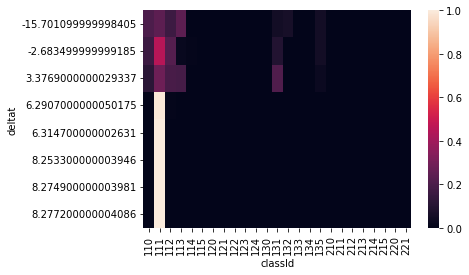

/tmp/ipykernel_1195946/3419850717.py:4: PerformanceWarning: indexing past lexsort depth may impact performance.
  tmp_xs = probvecs.xs((objectids, classifierids)).reset_index()[['deltat', 'classId', 'bin_prob']]


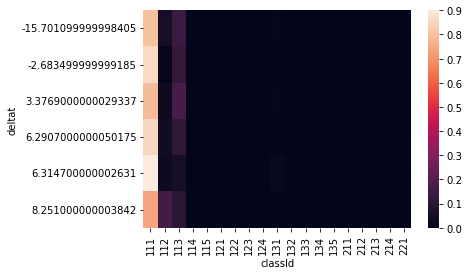

In [74]:
to_plot = []
for objectids in probvecs.index.levels[0][3:4]:
    for classifierids in probvecs.index.levels[1]:
        tmp_xs = probvecs.xs((objectids, classifierids)).reset_index()[['deltat', 'classId', 'bin_prob']]
        plot_one = pandas.pivot_table(tmp_xs, 
                                      values='bin_prob',
                                      columns='classId',
                                     index='deltat')
        seaborn.heatmap(plot_one)
        plt.show()
        
# plt.matshow(plot_one)

Next: bin the times, average values within time bin for same true type, gif of plasticc results fig 9 over time

In [59]:
help(pandas.pivot_table)

Help on function pivot_table in module pandas.core.reshape.pivot:

pivot_table(data: 'DataFrame', values=None, index=None, columns=None, aggfunc: 'AggFuncType' = 'mean', fill_value=None, margins: 'bool' = False, dropna: 'bool' = True, margins_name: 'str' = 'All', observed: 'bool' = False, sort: 'bool' = True) -> 'DataFrame'
    Create a spreadsheet-style pivot table as a DataFrame.
    
    The levels in the pivot table will be stored in MultiIndex objects
    (hierarchical indexes) on the index and columns of the result DataFrame.
    
    Parameters
    ----------
    data : DataFrame
    values : column to aggregate, optional
    index : column, Grouper, array, or list of the previous
        If an array is passed, it must be the same length as the data. The
        list can contain any of the other types (except list).
        Keys to group by on the pivot table index.  If an array is passed,
        it is being used as the same manner as column values.
    columns : column, Groupe

In [47]:
plot_one

classId     alertId  trueClassId   probability  \
diaObjectId classifierId                                                   
1000267     40                130  2000534000          111  0.000000e+00   
            40                120  2000534000          111  0.000000e+00   
            40                220  2000534000          111  0.000000e+00   
            40                215  2000534000          111  0.000000e+00   
            40                210  2000534000          111  0.000000e+00   
            40                124  2000534000          111  8.901676e-04   
            40                132  2000534000          111  6.651317e-02   
            40                110  2000534000          111  6.008820e-04   
            40                113  2000534000          111  4.202275e-01   
            40                112  2000534000          111  4.214732e-02   
            40                114  2000534000          111  2.738388e-05   
            40                111  2000534000          111  3.944930e-03   
            40                115  2000534000          111  6.783604e-08   
            40                131  2000534000          111  8.866317e-02   
            40                212  2000534000          111  4.091647e-06   
            40                221  2000534000          111  8.778129e-09   
            40                135  2000534000          111  3.769060e-01   
            40                122  2000534000          111  3.229373e-09   
            40                121  2000534000          111  1.758403e-06   
            40                133  2000534000          111  5.372418e-08   
            40                214  2000534000          111  5.959993e-06   
            40                123  2000534000          111  4.237358e-06   
            40                213  2000534000          111  4.608419e-05   
            40                211  2000534000          111  1.680773e-05   
            40                134  2000534000          111  3.950449e-07   
            40                113  2000534003          111  5.127397e-01   
            40                114  2000534003          111  1.309083e-06   
            40                221  2000534003          111  9.320312e-09   
            40                134  2000534003          111  2.736623e-09   
            40                211  2000534003          111  5.079021e-07   
            40                213  2000534003          111  1.188671e-06   
            40                123  2000534003          111  3.843949e-08   
            40                214  2000534003          111  8.075671e-07   
            40                133  2000534003          111  2.061028e-09   
            40                121  2000534003          111  2.877893e-07   
            40                122  2000534003          111  1.045240e-07   
            40                135  2000534003          111  1.747043e-01   
            40                212  2000534003          111  2.461595e-07   
            40                131  2000534003          111  9.526055e-02   
            40                115  2000534003          111  4.172352e-08   
            40                111  2000534003          111  5.401903e-03   
            40                130  2000534003          111  0.000000e+00   
            40                120  2000534003          111  0.000000e+00   
            40                220  2000534003          111  0.000000e+00   
            40                215  2000534003          111  0.000000e+00   
            40                210  2000534003          111  0.000000e+00   
            40                124  2000534003          111  7.488671e-06   
            40                132  2000534003          111  1.983675e-01   
            40                110  2000534003          111  1.074535e-04   
            40                112  2000534003          111  1.340653e-02   
            40                115  2000534004          111  1.707457e-08  

In [54]:
import seaborn

TODO: 

In [50]:
plot_one.pivot_table?

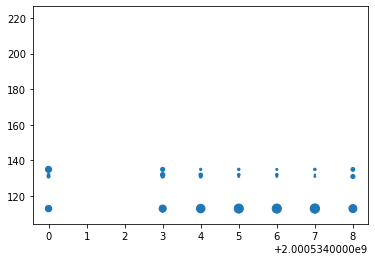

In [49]:
# import matplotlib as mpl
# from matplotlib import cm
plt.scatter(plot_one['alertId'], plot_one['classId'], s=100*plot_one['bin_prob'])

In [34]:
data['diaObjectId'].unique()

array([1000267, 1000292, 1000316, 1000448, 1000674, 1000757, 1000776,
       1001197, 1001216, 1001372, 1001409, 1001747, 1002071, 1002288,
       1002647, 1002657, 1002842, 1002970, 1003312, 1003330, 1003377,
       1003402, 1003722, 1003806, 1003878, 1004142, 1004205, 1004280,
       1004461, 1004475, 1004497, 1004610, 1004688, 1004713, 1004893,
       1004913, 1004931, 1004978, 1005358, 1005627, 1005628, 1005646,
       1005738, 1005787, 1005839, 1005956, 1006052, 1006147, 1006335,
       1006434, 1006466, 1006592, 1006701, 1007021, 1007116, 1007230,
       1007364, 1007486, 1007857, 1007858, 1007987, 1008033, 1008462,
       1008473, 1008505, 1008579, 1008732])

(array([3191., 2453., 1287.,    0.,    0.,    0.,    0.,    0.,    0.,
        3069.]),
 array([110. , 121.1, 132.2, 143.3, 154.4, 165.5, 176.6, 187.7, 198.8,
        209.9, 221. ]),
 <BarContainer object of 10 artists>)

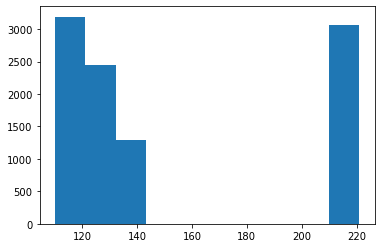

In [35]:
plt.hist(data['classId'])

In [36]:
data["bin_prob"] = data['probability'].round(decimals=2)

voila they sum to 1!

In [37]:
data.groupby(['alertId', "classifierId"])["probability"].sum()

alertId     classifierId
2000534000  40              1.0
2000534003  40              1.0
2000534004  40              1.0
2000534005  40              1.0
2000534006  40              1.0
2000534007  40              1.0
2000534008  40              1.0
2000584063  40              1.0
            44              1.0
2000632039  40              1.0
2000632041  40              1.0
            44              1.0
2000632044  40              1.0
2000896004  40              1.0
            44              1.0
2000896012  40              1.0
            44              1.0
2000896015  40              1.0
            44              1.0
2000896016  40              1.0
            44              1.0
2000896017  40              1.0
            44              1.0
2000896018  44              1.0
2000896019  40              1.0
2000896020  40              1.0
2000896021  40              1.0
2001348001  40              1.0
            44              1.0
2001348004  40              1.0
            44 